In [16]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, OneHotEncoder
from kmodes.kprototypes import KPrototypes
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')
import gower
import joblib

In [17]:
def data_access():
    project_id = "model-lookups-mysql"
    client = bigquery.Client(project=project_id)
    query = """SELECT * FROM `model-lookups-mysql.model_lookup_mysql.bf_cons_lookup`
               WHERE deceased = 0 AND dma_sensitive = 0 AND bf_sensitive = 0 AND credit_score >= 300"""
    job = client.query(query)
    data = job.to_dataframe()
    return data
def select_columns(data):
    sc=['calculated_gender', 'calculated_age','have_personal_loan' ,
     'is_govt_employed', 'is_employed','credit_score', 'is_home_owners', 
     'is_car_owners' , 'is_under_debtreview']
    data=data[sc]
    cat_col_no_object=['is_govt_employed', 'is_employed', 
    'is_home_owners', 'is_car_owners' , 'is_under_debtreview','have_personal_loan']
    data[cat_col_no_object]= data[cat_col_no_object].astype(str)
    others=[  'is_govt_employed', 'is_home_owners', 'is_car_owners' , 'is_under_debtreview','have_personal_loan']
    recoding_others={'0': 'No', '1':'Yes'}
    data[others]=data[others].replace(recoding_others)
    recoding_employed={'0': 'Unknown/Unemployed', '1':'Employed'}   
    data['is_employed']=data['is_employed'].replace(recoding_employed)
    data = data[data['calculated_gender'] != 'U']
    return data
def remove_outliers(data):
    for column in data.select_dtypes(include=['number']).columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data
cat_cols=['calculated_gender','have_personal_loan' ,
     'is_govt_employed', 'is_employed', 'is_home_owners', 
     'is_car_owners' , 'is_under_debtreview']
def encoded_data(data):
    cat_cols = data.select_dtypes(include=['object']).columns.tolist()
    encoder = OneHotEncoder(sparse_output=False)
    one = encoder.fit_transform(data[cat_cols])
    one_df = pd.DataFrame(one, columns=encoder.get_feature_names_out(cat_cols), index=data.index)
    encoded = pd.concat([data, one_df], axis=1)
    encoded = encoded.drop(data[cat_cols], axis=1)
    return encoded

scaler = StandardScaler()
def scaled_data(data):
    num_cols = ["credit_score", "calculated_age"]
    numerical_data = scaler.fit_transform(data[num_cols])
    data[num_cols] = numerical_data
    return data

def transform_back(data):
    num_cols = ["credit_score", "calculated_age"]
    numerical_data = scaler.inverse_transform(data[num_cols])
    data[num_cols] = numerical_data
    return data




In [18]:
data = data_access()
selected_data = select_columns(data)
data_clean = remove_outliers(selected_data)
encode = encoded_data(data_clean)
scaled_data = scaled_data(encode)

In [19]:
scaled_data

,calculated_age,credit_score,calculated_gender_F,calculated_gender_M,have_personal_loan_No,have_personal_loan_Yes,is_govt_employed_No,is_govt_employed_Yes,is_employed_Employed,is_employed_Unknown/Unemployed,is_home_owners_No,is_home_owners_Yes,is_car_owners_No,is_car_owners_Yes,is_under_debtreview_No,is_under_debtreview_Yes
0,1.677685,-1.534847,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.677685,-0.458966,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.610277,1.477621,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.521327,1.122112,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.788179,0.130430,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13071428,-1.346636,-1.076428,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
13071429,-1.257686,-0.561876,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
13071430,-1.257686,-0.851896,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
13071431,-1.168735,-0.973518,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [20]:
kmeans=joblib.load('/Users/senelisiwemuradzikwa/Desktop/Offernet/Client/Lewis/v2/kmeans_model.pkl')

In [21]:
new_clusters = kmeans.predict(scaled_data)
scaled_data.insert(0,"Cluster", new_clusters, True)
scaled_data

,Cluster,calculated_age,credit_score,calculated_gender_F,calculated_gender_M,have_personal_loan_No,have_personal_loan_Yes,is_govt_employed_No,is_govt_employed_Yes,is_employed_Employed,is_employed_Unknown/Unemployed,is_home_owners_No,is_home_owners_Yes,is_car_owners_No,is_car_owners_Yes,is_under_debtreview_No,is_under_debtreview_Yes
0,1,1.677685,-1.534847,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1,1.677685,-0.458966,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,2,0.610277,1.477621,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,2,0.521327,1.122112,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1,0.788179,0.130430,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13071428,0,-1.346636,-1.076428,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
13071429,0,-1.257686,-0.561876,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
13071430,0,-1.257686,-0.851896,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
13071431,0,-1.168735,-0.973518,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [22]:
original_data = transform_back(scaled_data)
original_data

,Cluster,calculated_age,credit_score,calculated_gender_F,calculated_gender_M,have_personal_loan_No,have_personal_loan_Yes,is_govt_employed_No,is_govt_employed_Yes,is_employed_Employed,is_employed_Unknown/Unemployed,is_home_owners_No,is_home_owners_Yes,is_car_owners_No,is_car_owners_Yes,is_under_debtreview_No,is_under_debtreview_Yes
0,1,66.0,516.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1,66.0,631.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,2,54.0,838.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,2,53.0,800.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1,56.0,694.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13071428,0,32.0,565.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
13071429,0,33.0,620.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
13071430,0,33.0,589.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
13071431,0,34.0,576.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [23]:
data_clean.insert(0,"Cluster", new_clusters, True)
data_clean

,Cluster,calculated_gender,calculated_age,have_personal_loan,is_govt_employed,is_employed,credit_score,is_home_owners,is_car_owners,is_under_debtreview
0,1,F,66,No,No,Unknown/Unemployed,516,No,No,No
1,1,M,66,Yes,No,Unknown/Unemployed,631,No,No,No
2,2,M,54,No,No,Unknown/Unemployed,838,Yes,Yes,No
3,2,M,53,No,No,Unknown/Unemployed,800,Yes,Yes,No
4,1,M,56,Yes,Yes,Unknown/Unemployed,694,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...
13071428,0,M,32,Yes,No,Unknown/Unemployed,565,No,No,No
13071429,0,F,33,No,No,Unknown/Unemployed,620,No,No,No
13071430,0,F,33,No,No,Unknown/Unemployed,589,No,No,No
13071431,0,F,34,No,No,Unknown/Unemployed,576,No,No,No


Categorical columns: Index(['calculated_gender', 'have_personal_loan', 'is_govt_employed',
       'is_employed', 'is_home_owners', 'is_car_owners',
       'is_under_debtreview'],
      dtype='object')

Value counts of column calculated_gender:
calculated_gender
F    60.04
M    39.96
Name: proportion, dtype: float64

Value counts of column have_personal_loan:
have_personal_loan
No     75.06
Yes    24.94
Name: proportion, dtype: float64

Value counts of column is_govt_employed:
is_govt_employed
No     97.5
Yes     2.5
Name: proportion, dtype: float64

Value counts of column is_employed:
is_employed
Unknown/Unemployed    80.18
Employed              19.82
Name: proportion, dtype: float64

Value counts of column is_home_owners:
is_home_owners
No     91.22
Yes     8.78
Name: proportion, dtype: float64

Value counts of column is_car_owners:
is_car_owners
No     90.98
Yes     9.02
Name: proportion, dtype: float64

Value counts of column is_under_debtreview:
is_under_debtreview
No     97.7
Yes 

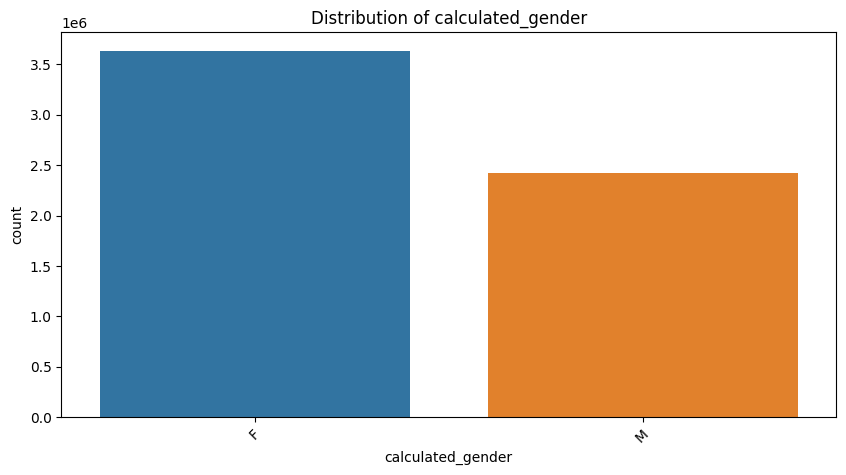

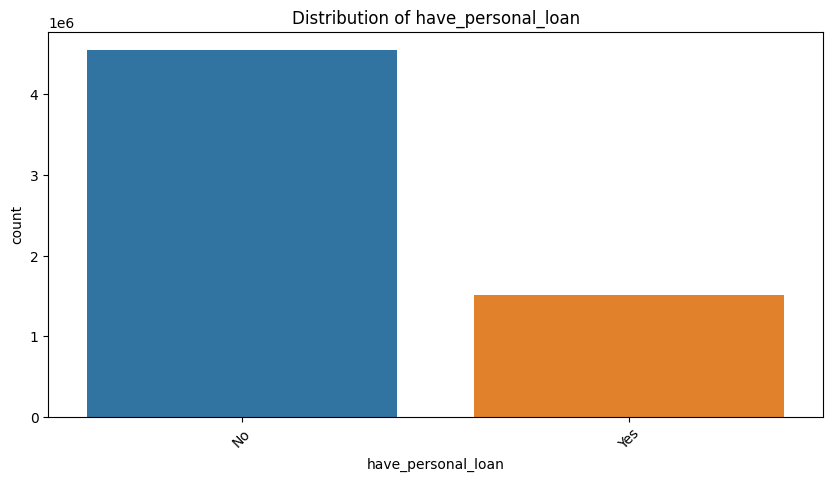

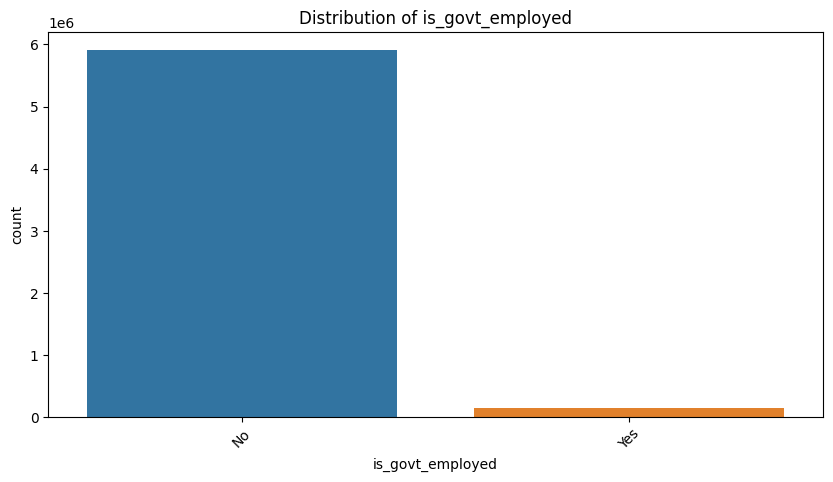

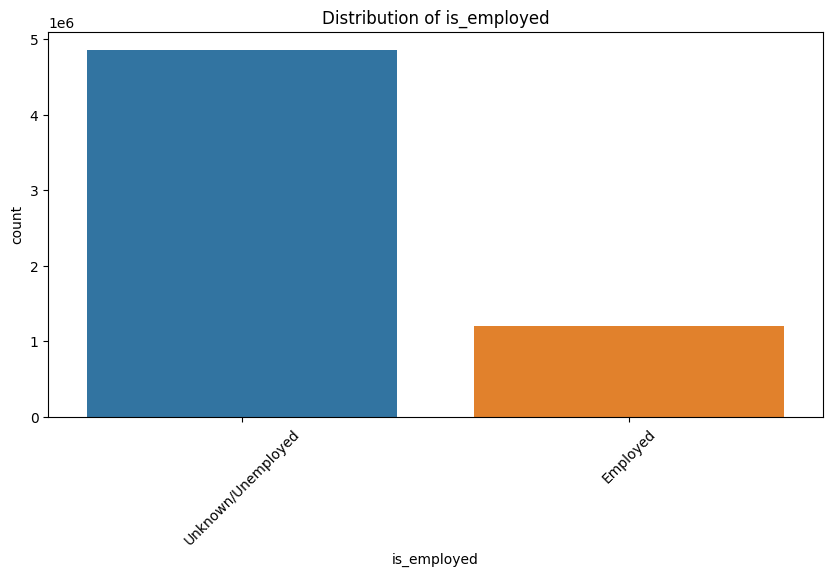

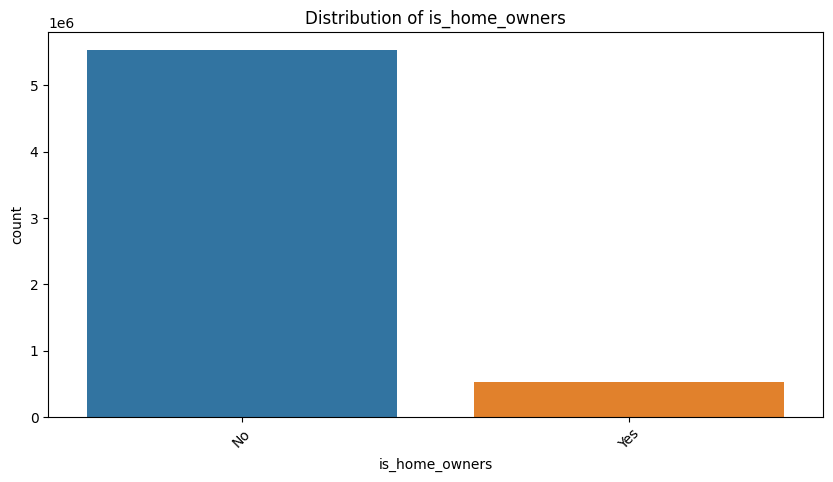

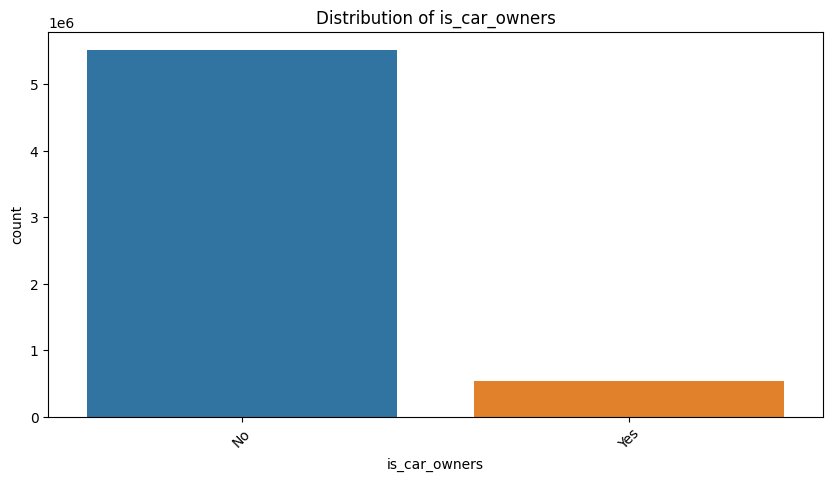

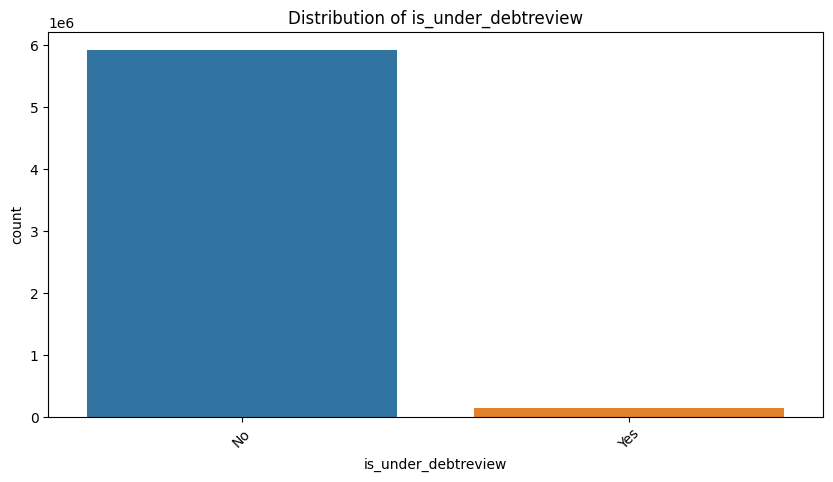

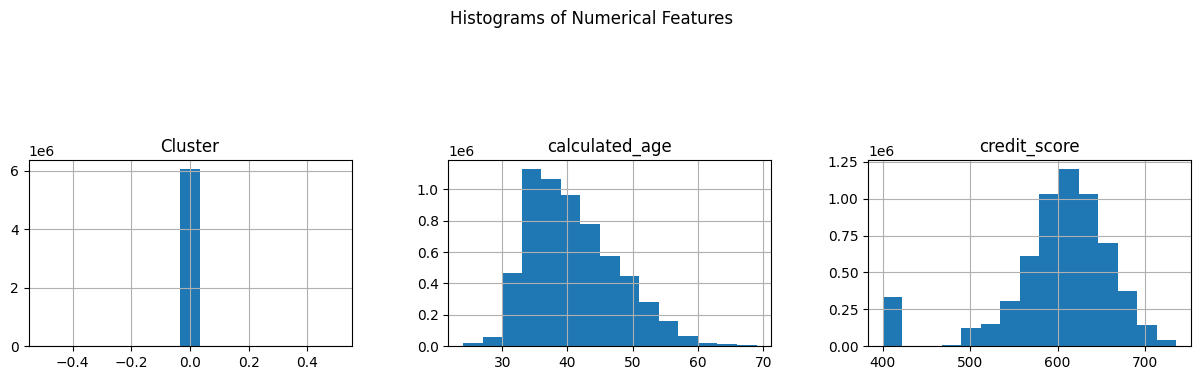

,Cluster,calculated_age,credit_score
count,6056168.0,6056168.0,6056168.0
mean,0.0,40.435943,600.605525
std,0.0,6.801224,64.591958
min,0.0,24.0,400.0
25%,0.0,35.0,579.0
50%,0.0,39.0,610.0
75%,0.0,45.0,640.0
max,0.0,69.0,736.0


In [24]:
filtered_data_0 = data_clean[data_clean['Cluster'] == 0]
filtered_data_0
categorical_cols = filtered_data_0.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)
for col in categorical_cols:
    print(f"\nValue counts of column {col}:")
    print((filtered_data_0[col].value_counts(normalize=True) * 100).round(2))  # Round to two decimal places
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=filtered_data_0)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()
filtered_data_0.hist(bins=15, figsize=(15, 15), layout=(5, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()
filtered_data_0.describe()


Categorical columns: Index(['calculated_gender', 'have_personal_loan', 'is_govt_employed',
       'is_employed', 'is_home_owners', 'is_car_owners',
       'is_under_debtreview'],
      dtype='object')

Value counts of column calculated_gender:
calculated_gender
F    51.09
M    48.91
Name: proportion, dtype: float64

Value counts of column have_personal_loan:
have_personal_loan
Yes    52.12
No     47.88
Name: proportion, dtype: float64

Value counts of column is_govt_employed:
is_govt_employed
No     89.68
Yes    10.32
Name: proportion, dtype: float64

Value counts of column is_employed:
is_employed
Employed              56.17
Unknown/Unemployed    43.83
Name: proportion, dtype: float64

Value counts of column is_home_owners:
is_home_owners
Yes    60.91
No     39.09
Name: proportion, dtype: float64

Value counts of column is_car_owners:
is_car_owners
No     53.71
Yes    46.29
Name: proportion, dtype: float64

Value counts of column is_under_debtreview:
is_under_debtreview
No     94.06
Y

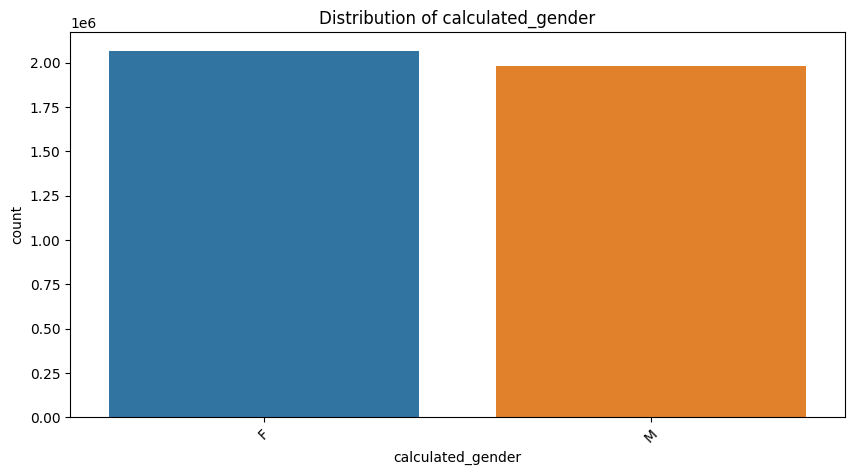

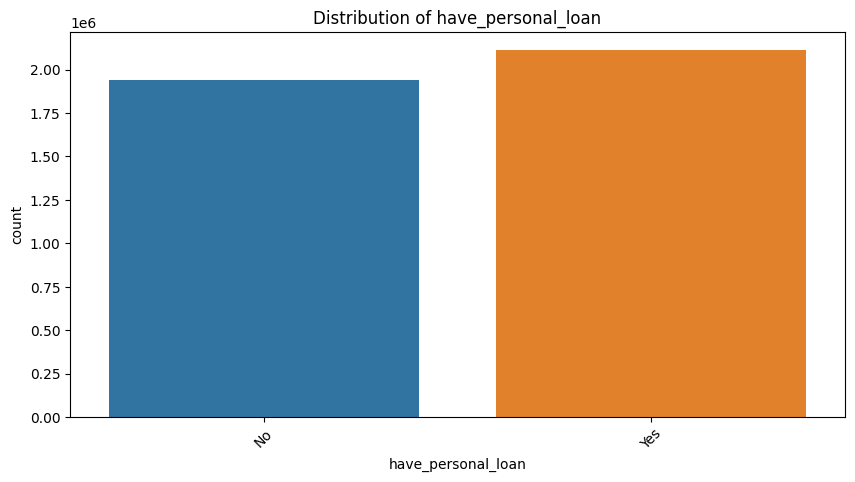

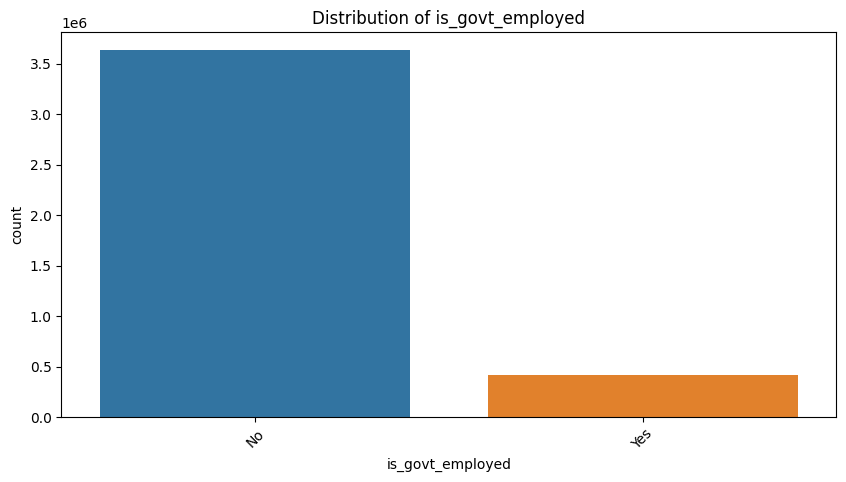

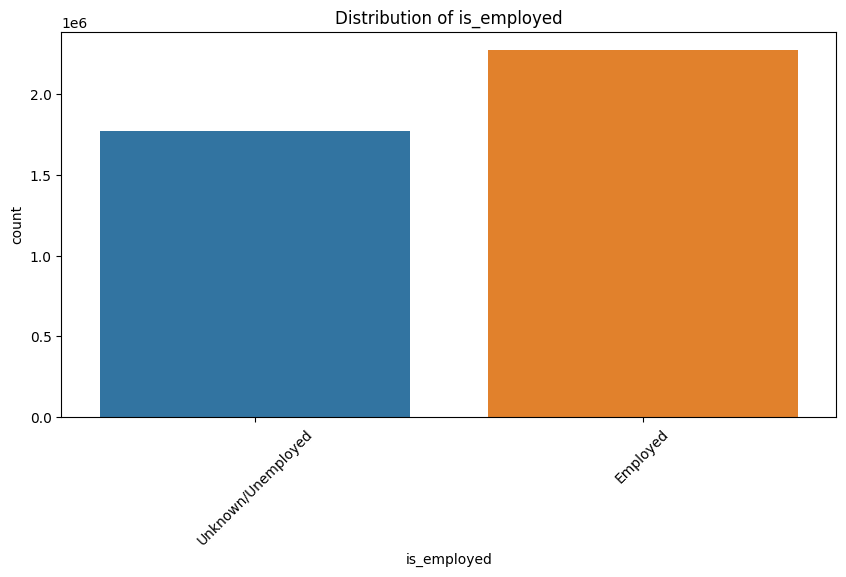

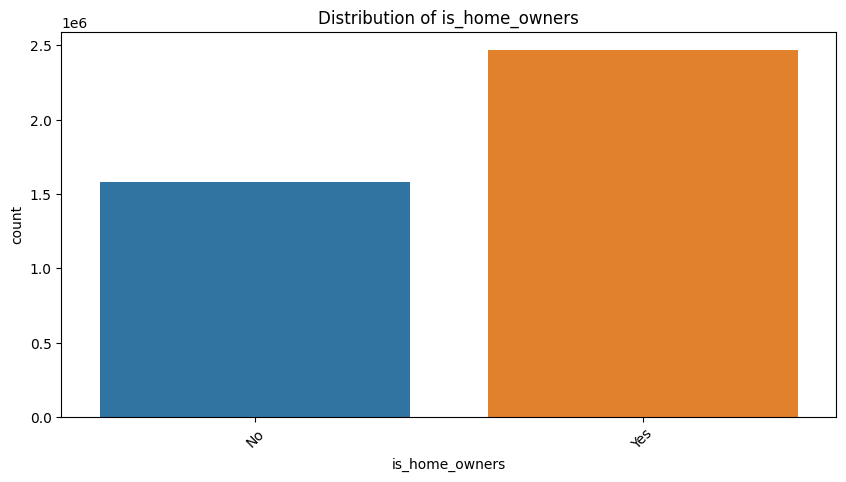

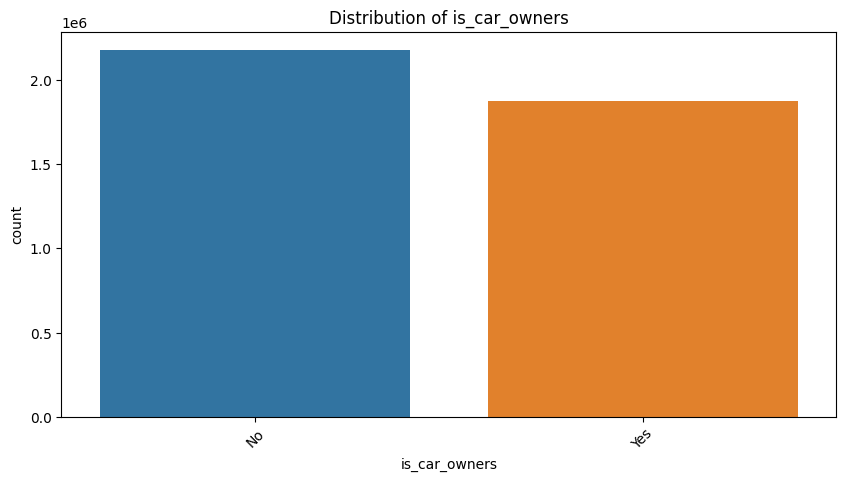

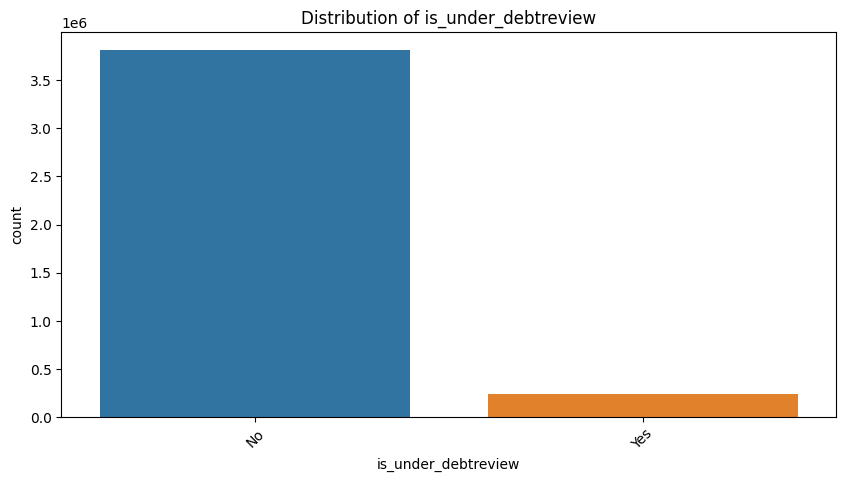

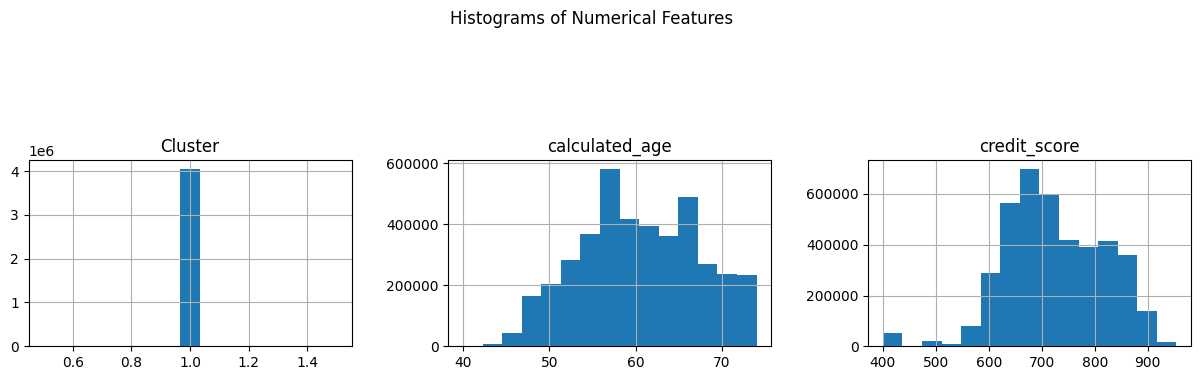

,Cluster,calculated_age,credit_score
count,4049550.0,4049550.0,4049550.0
mean,1.0,60.463458,723.626097
std,0.0,6.863244,94.634673
min,1.0,40.0,400.0
25%,1.0,55.0,658.0
50%,1.0,60.0,713.0
75%,1.0,66.0,799.0
max,1.0,74.0,954.0


In [25]:
filtered_data_1 = data_clean[data_clean['Cluster'] == 1]
filtered_data_1
categorical_cols = filtered_data_1.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)
for col in categorical_cols:
    print(f"\nValue counts of column {col}:")
    print((filtered_data_1[col].value_counts(normalize=True) * 100).round(2))  # Round to two decimal places
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=filtered_data_1)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()
filtered_data_1.hist(bins=15, figsize=(15, 15), layout=(5, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()
filtered_data_1.describe()


Categorical columns: Index(['calculated_gender', 'have_personal_loan', 'is_govt_employed',
       'is_employed', 'is_home_owners', 'is_car_owners',
       'is_under_debtreview'],
      dtype='object')

Value counts of column calculated_gender:
calculated_gender
F    55.79
M    44.21
Name: proportion, dtype: float64

Value counts of column have_personal_loan:
have_personal_loan
Yes    53.72
No     46.28
Name: proportion, dtype: float64

Value counts of column is_govt_employed:
is_govt_employed
No     88.93
Yes    11.07
Name: proportion, dtype: float64

Value counts of column is_employed:
is_employed
Unknown/Unemployed    52.27
Employed              47.73
Name: proportion, dtype: float64

Value counts of column is_home_owners:
is_home_owners
No     54.82
Yes    45.18
Name: proportion, dtype: float64

Value counts of column is_car_owners:
is_car_owners
Yes    57.45
No     42.55
Name: proportion, dtype: float64

Value counts of column is_under_debtreview:
is_under_debtreview
No     97.11
Y

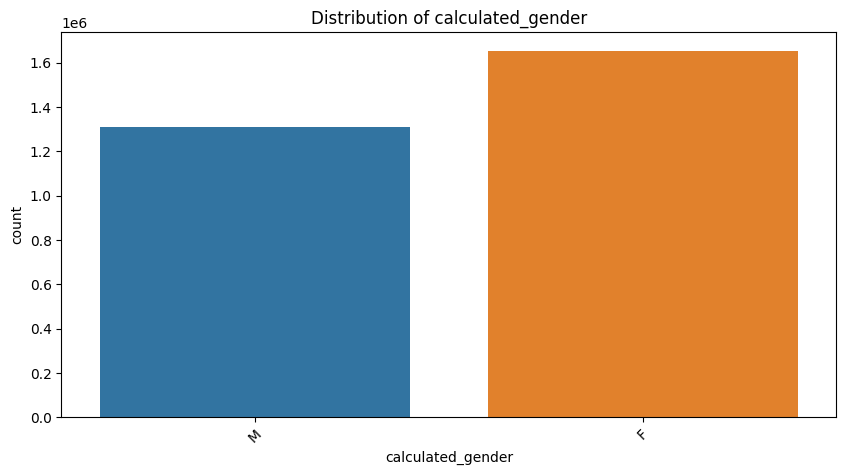

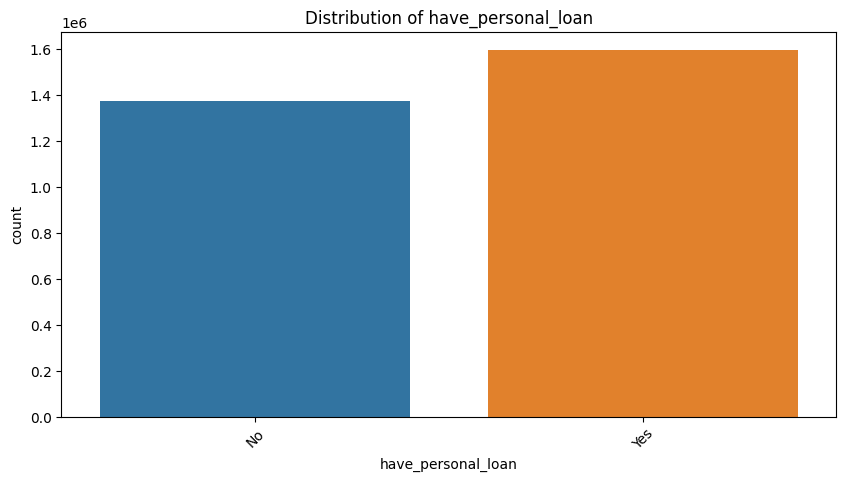

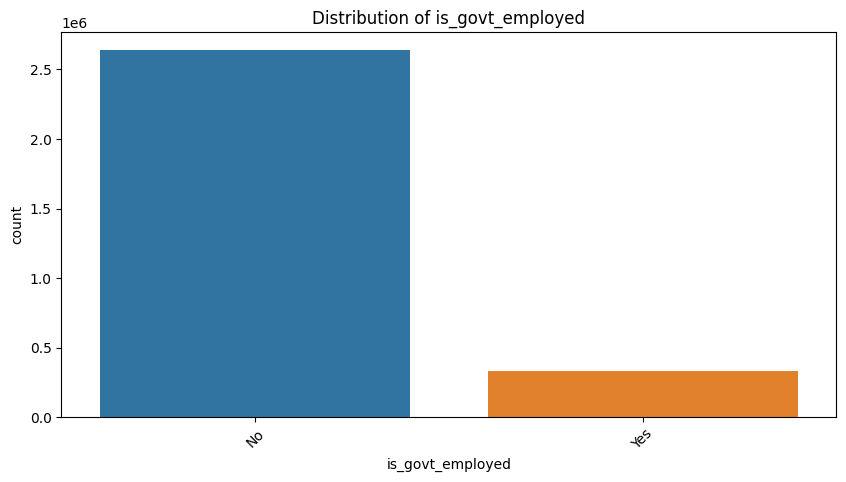

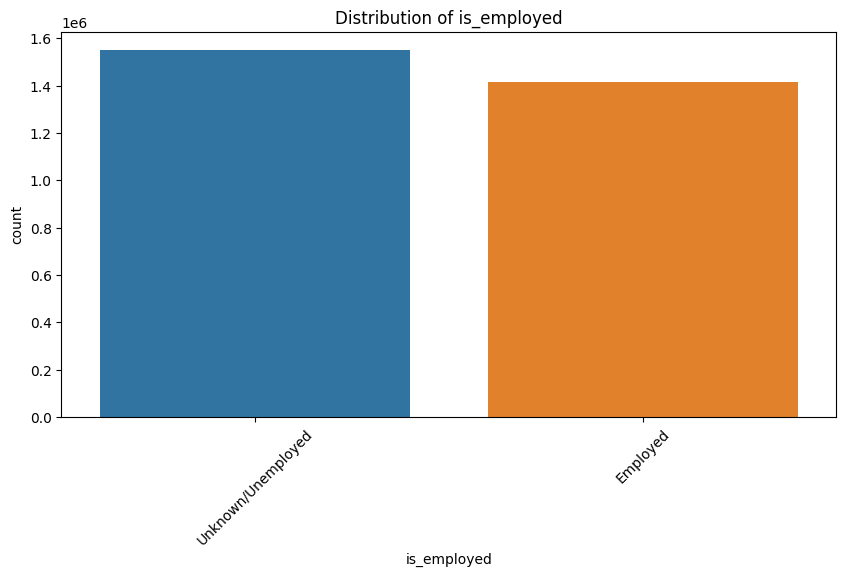

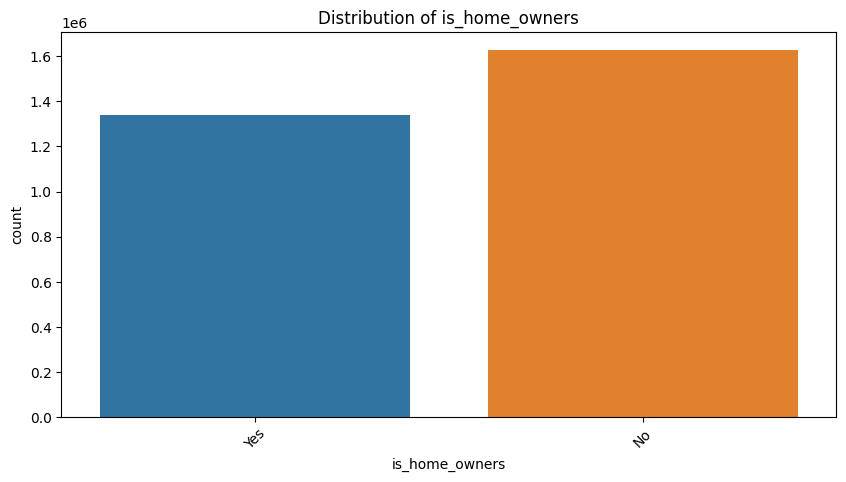

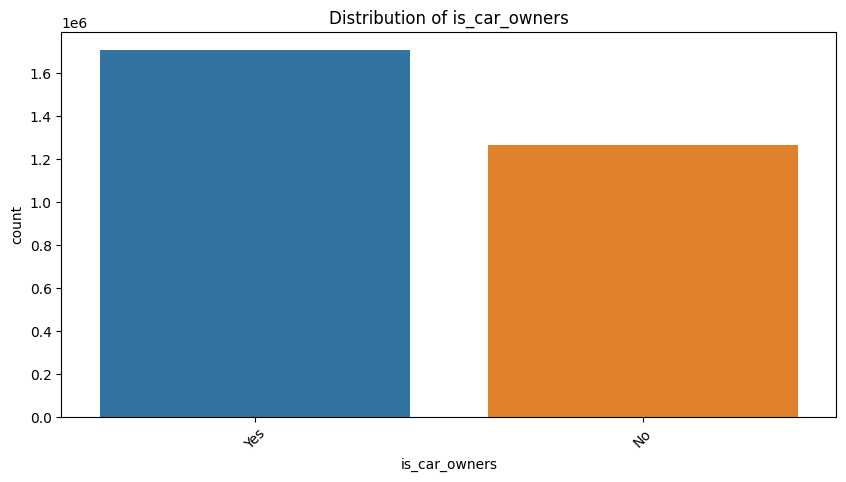

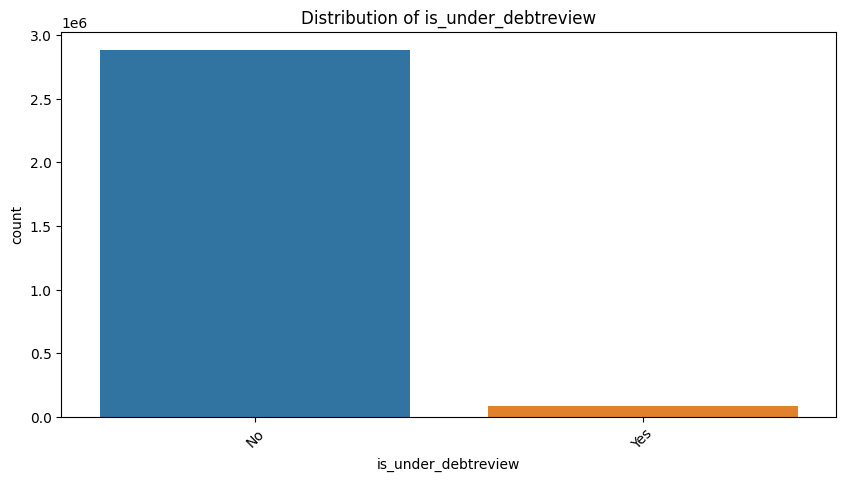

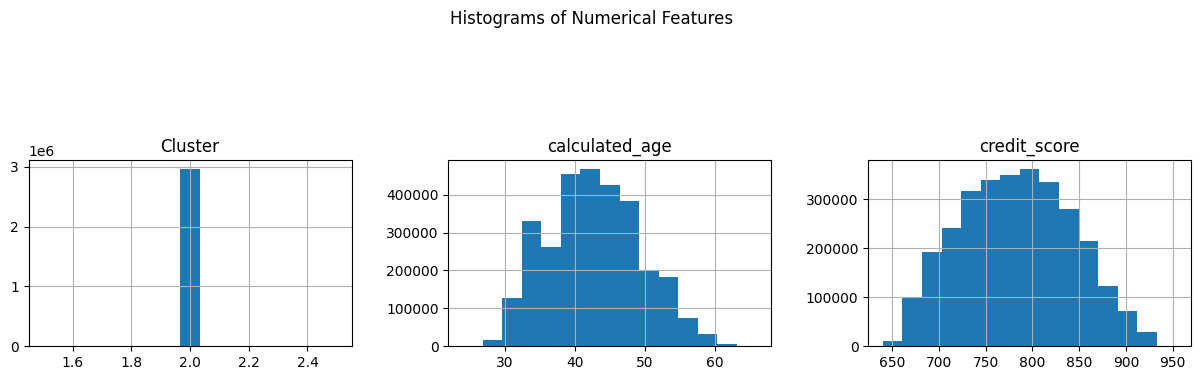

,Cluster,calculated_age,credit_score
count,2965698.0,2965698.0,2965698.0
mean,2.0,42.633708,782.817002
std,0.0,6.61819,59.720768
min,2.0,24.0,640.0
25%,2.0,38.0,737.0
50%,2.0,42.0,783.0
75%,2.0,48.0,827.0
max,2.0,66.0,954.0


In [26]:
filtered_data_2 = data_clean[data_clean['Cluster'] == 2]
filtered_data_2
categorical_cols = filtered_data_2.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)
for col in categorical_cols:
    print(f"\nValue counts of column {col}:")
    print((filtered_data_2[col].value_counts(normalize=True) * 100).round(2))  # Round to two decimal places
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=filtered_data_2)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()
filtered_data_2.hist(bins=15, figsize=(15, 15), layout=(5, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()
filtered_data_2.describe()

In [27]:
finaldata=pd.concat([data.reset_index(drop=True), pd.DataFrame(data_clean, columns=['Cluster'])], axis=1)

: 

In [ ]:
project_id = 'model-lookups-mysql'
dataset_id = 'Lewis'
table_id = 'consumerdataclustered'
finaldata.columns = [col[:300] for col in finaldata.columns]
destination_table = f"{dataset_id}.{table_id}"
table_schema = None 
finaldata.to_gbq(destination_table, project_id=project_id, if_exists='replace', table_schema=table_schema, location='europe-west4')

GenericGBQException: Reason: 400 POST https://bigquery.googleapis.com/upload/bigquery/v2/projects/model-lookups-mysql/jobs?uploadType=resumable: Error: 3848323